# This is the model comparsion notebook. 
We will cover a bunch of models with a baseline data from a English Premier League, to distingiush potential and next steps.

The main reasoning behind this research is to create the algobetting robot. Whilst mode odds on home wins and distribution are around 1,16(distribution: ~43%), away wins 1,78(dist: ~34%) and draws 3,38(dist: ~23%), it means that:
(1,16*0,43+1,78*0,34+3,38*0,23) * accuracy of prediction should set a baseline for a ROI of this robot.

And math is very clear here: 

In [37]:
sum_of_odds = 1.16*0.43+1.78*0.34+3.38*0.23
print(f"The sum of odds in one season, if we type everything correct is: {round(sum_of_odds, 3)}")
print(f"So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate {round(1/sum_of_odds*100, 4)}% times.")

## data based on EPL season of 2021

The sum of odds in one season, if we type everything correct is: 1.881
So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate 53.1519% times.


## So we'll be covering following algorithms:

1. SKlearn RandomForestClassifier (no need of explanation)
2. XGBoost Classifier (no need of explanation)
3. PyTorch TabNet implementationby Dreamquark-ai:
  <br>  a) https://github.com/dreamquark-ai/tabnet - official docs of PyTorch implementation of the original algorithm
  <br>  b) https://arxiv.org/abs/1908.07442 - official research papers of TabNet
<br> c) https://www.geeksforgeeks.org/tabnet/ - a quick guide over the TabNet

4. DeepInisght with DeppInsight like architecture:
  <br>  a) DeepInsight paper: https://www.nature.com/articles/s41598-019-47765-6 - a methodology of converting tabular data to Images, article in Nature with some data
 <br>   b) https://github.com/nicomignoni/tab2img - a documentation of the implemenation of DeepInsight in a python library 
<br>    c) Disclaimer: this is a baseline approach, so I decided just to implement the one leg of proposed net. 

In [38]:
# Let's start from importing and mounting drive, cause we'll be working on a dataset prepared before in a following notebook:
# Notebook for Data Gathering https://github.com/SquareGraph/FootballPredictionsModel/blob/main/DataGathering_from_Soccerdata.ipynb
from IPython.utils.text import Path
from google.colab import drive 
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Paths declaration
path = Path('/content/drive/MyDrive/Github/FootballPredictionsModel')
data = 'data'

In [40]:
#Some standard imports
import pandas as pd
import numpy as np

In [41]:
main = pd.read_csv(path/data/"with_fifa_raw.csv") ; print(main.shape) # We have a lot of features here, 141!
main.head()

(380, 141)


,Unnamed: 0,date_x,home_team,away_team,game_id,Goal_x,Off Target_x,Saved_x,Woodwork_x,<10_x,...,33,34,35,36,37,38,39,40,41,42
0,0,2021-08-13 00:00:00,Brentford,Arsenal,3adf2aa7,1.500000,2.8,1.00,0.0,3.6,...,-2.757576,0.393939,-0.333333,-3.060606,-1.636364,-2.242424,-2.060606,-1.484849,-0.545455,-1.424242
1,1,2021-08-14 00:00:00,Burnley,Brighton & Hove Albion,4eb36e37,1.000000,2.6,2.00,0.0,2.2,...,1.060606,2.666667,0.212121,0.181818,-0.030303,0.333333,0.212121,0.484849,-0.454545,0.363636
2,2,2021-08-14 00:00:00,Chelsea,Crystal Palace,6f454493,1.400000,4.0,4.25,0.0,3.8,...,5.939394,3.787879,4.636363,5.151515,0.000000,1.484849,1.454546,0.151515,-0.636364,-1.666667
3,3,2021-08-14 00:00:00,Everton,Southampton,c99ebbf5,1.666667,4.0,2.00,0.0,3.0,...,6.636363,3.484849,1.878788,1.636364,0.181818,0.848485,0.363636,0.484849,0.424242,0.515151
4,4,2021-08-14 00:00:00,Leicester City,Wolverhampton Wanderers,0b346a62,1.000000,3.6,2.50,0.0,3.0,...,3.939394,3.545454,4.060606,3.151515,4.393940,3.545454,4.121212,3.454546,4.878788,2.636364


In [42]:
# list(main.columns)

In [43]:
main.dtypes[main.dtypes == "object"] # And here all non-numerical categories. 

date_x       object
home_team    object
away_team    object
game_id      object
date_y       object
dtype: object

# What to do with those features.
A Quick explanation:

1. Object data types:
   <br>a) We want to drop date_x and date_y features (as it seems not relevant to the game performance, without an information about additional games from other competition, and potential fatigue). From domain knowledge, raw date of a game it's a rubbish data I strongly believe.
    <br> b) Home_team and away_team - assign each team a number, and treat them like every other numerical data. There's some logic behind this reasoning. Explain further in the document.
    <br> c) game_id - absolutely unnecessary.

2.  Numerical data types to drop from the features:

    a) FTR - those are our Y values. We want to drop them before assining to the X values.
   <br> b) D_HT, home_point,draw_points,away_points - A lost remains of some computation did during that processing. Absolutely to drop.
  <br>  c) Unnamed: 0 - index like, probably effect of merging without droping index params. Drop.

3. Numerical data types - Legend
   <br> a) Columns named from 0 to 42: it's a SoFifa mean params, substracted between home and away.
  <br>  b) home_rank, away_rank - ELO Rank at the day of a game
  <br> c) all duplicated columns - rolling average (5 games window) for each team performance






# Team name transofmration

Probably the team name may also affect the game result. For example if you are playing against strong rival your mental approach may vary from challenging the weaker one. So let's translate team names into integer values from 1 to 20.

In [44]:
team_integers = dict(zip(np.unique(main.home_team.to_numpy()),np.arange(1,21))) #dict from zip from unique team names labeled by the np arange.
main.replace(team_integers, inplace=True) #replace all through dictionary method.

# Prepare Raw, unnormalized data for initial baseline training.

We want to start with a baseline models just from the raw data.
But let's also check if time series character vary training or not. So we will build two different datasets. One that will be randomly splited, and the second one that takes first 80% of games for a training dataset and predict on the last 20%. Let's call them X_ts,y_ts for timeserieswise variation, and X_rand, y_rand for randomly splitted.

In [45]:
main_dropped = main.drop(["date_x","date_y","game_id","Unnamed: 0","D_HT","home_point","draw_points","away_points"],axis=1) # we are dropping all columns mentioned above

In [46]:
y = main_dropped.FTR.to_numpy() #labels
X = main_dropped.drop(["FTR"],axis=1).fillna(0).to_numpy() ## all nan comes from the effect of calculating rolling average (division by 0 at some point) or no records, so filling with 0 is not a bad idea.

In [48]:
## We will use our own train test split, because want to keep chronological order as those are time series data.

def train_test_split_ts(features, targets, train_size=0.8):

    """Returns two tuples of Train and test sests, in X,y order."""

    TRAIN_SIZE = int(features.shape[0]*train_size)
    X_ts_train, y_ts_train = features[:TRAIN_SIZE], targets[:TRAIN_SIZE]
    X_ts_test, y_ts_test = features[TRAIN_SIZE:], targets[TRAIN_SIZE:]



    return (X_ts_train, y_ts_train), (X_ts_test, y_ts_test)

In [49]:
train_ts, test_ts = train_test_split_ts(X,y) # split into tuples

In [50]:
#unpack tuples for all other models
X_train_ts, y_train_ts = train_ts 
X_test_ts, y_test_ts = test_ts

# First model RandomForestClassifier from sklearn
We starts with a RandomForest for our absolute baseline.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [52]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [53]:
rf.fit(X_train_ts, y_train_ts) # train the baseline model

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [54]:
rf_preds = np.argmax(rf.predict_proba(X_test_ts), axis=1) # make prediction and call the argmax to have an index of the highest probability

In [55]:
rf_acc = accuracy_score(y_test_ts, rf_preds) ; rf_acc#np.sum((preds == y_test_ts).astype(float))/preds.shape[0] ; accuracy # calculate the model accuracy.

0.5394736842105263

In [56]:
def check_odds(x):

    """helper function to collect Avg odds per our prediction. To apply on a DataFrame"""

    if x.FTR == 0:
        return x.AvgH
    elif x.FTR == 1:
        return x.AvgA
    elif x.FTR == 2:
        return x.AvgD

In [57]:
## check the bookmakers odds score

def check_score(main_df: pd.core.frame.DataFrame, predictions: np.array):
    
    """A simple function that returns the DataFrame of correct results and a score"""

    main_df["predictions"] = 0
    main_df.predictions[304:] = predictions

    comparsion_of_predictions = main_df[["FTR","predictions","AvgH","AvgA","AvgD"]][304:]
    filter = comparsion_of_predictions.FTR == comparsion_of_predictions.predictions

    filtered = comparsion_of_predictions[filter] 
    filtered["score_odds"] = filtered.apply(lambda x: check_odds(x), axis=1)
    score = filtered.sum(axis=0)["score_odds"]

    return filtered, score


    


In [58]:
compare_rf, score_rf = check_score(main, rf_preds) ; score_rf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


73.39999999999999

In [59]:
avg_odds_per_bet_rf = compare_rf.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_rf

1.7902439024390242

# RandomForestClassifier

So our accuracy is over the target (nearly 54%) but it looks like investing 1 dollar per each game of the last 76 game wouldn't be the best idea in the world, cause our return was 73,4 dollars. But still better then random, as we have only 33% chances of good bet!

# XGBoost - Baseline model 2

In [60]:
import xgboost as xgb

In [61]:
model_xgb_ = xgb.XGBClassifier(learning_rate=0.1,
                              max_depth=5,
                              n_estimators=100,
                              subsample=0.5,
                              colsample_bytree=0.5,
                              eval_metric='mlogloss',
                              verbosity=1) #Hyperparams



model_xgb_.fit(X_train_ts, y_train_ts, early_stopping_rounds=100, eval_set=[(X_test_ts, y_test_ts)], verbose=True) #train the model

[0]	validation_0-mlogloss:1.07159
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.05318
[2]	validation_0-mlogloss:1.04096
[3]	validation_0-mlogloss:1.01734
[4]	validation_0-mlogloss:1.00851
[5]	validation_0-mlogloss:0.993597
[6]	validation_0-mlogloss:0.988864
[7]	validation_0-mlogloss:0.981035
[8]	validation_0-mlogloss:0.980294
[9]	validation_0-mlogloss:0.975226
[10]	validation_0-mlogloss:0.973907
[11]	validation_0-mlogloss:0.969354
[12]	validation_0-mlogloss:0.971531
[13]	validation_0-mlogloss:0.96034
[14]	validation_0-mlogloss:0.951886
[15]	validation_0-mlogloss:0.949096
[16]	validation_0-mlogloss:0.942552
[17]	validation_0-mlogloss:0.944439
[18]	validation_0-mlogloss:0.945999
[19]	validation_0-mlogloss:0.941998
[20]	validation_0-mlogloss:0.950489
[21]	validation_0-mlogloss:0.95129
[22]	validation_0-mlogloss:0.956154
[23]	validation_0-mlogloss:0.955074
[24]	validation_0-mlogloss:0.954337
[25]	validation_0-mlogloss:0.951503
[26]	valida

XGBClassifier(colsample_bytree=0.5, eval_metric='mlogloss', max_depth=5,
              objective='multi:softprob', subsample=0.5)

In [62]:
xgboost_test_preds = model_xgb_.predict_proba(X_test_ts).argmax(axis=1) # make predictions and find the index of the max predictions by row

In [63]:
xgboost_acc_test = accuracy_score(y_test_ts, xgboost_test_preds) ; xgboost_acc_test # calculate Accuracy

0.5526315789473685

In [64]:
compare_xgb, score_xgb = check_score(main, xgboost_test_preds) # calculate bookmakers 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
score_xgb # And still we are below our initial investment.

75.53

In [66]:
avg_odds_per_bet_xgb = compare_xgb.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_xgb

1.7983333333333333

# XGBoost baseline performance
It was slightly better then RandomForrest, but we are still underperforming. From the other hand, we are at the level of the bookmakers accuracy, so not bad for the second shot.

# TabNet Baseline

In [67]:
!pip install pytorch_tabnet==3.1.1 # You have to install tabnet, colab doesn't come with this one included

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
from pytorch_tabnet.tab_model import TabNetClassifier #this is the class will be using
import torch #this one is for the optimizer

In [69]:
model_tabnet = TabNetClassifier(n_d=64, n_a=64, n_steps=10,
    gamma=0, n_independent=2, n_shared=2,
    lambda_sparse=1e-5, momentum=1, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.5,
                     "step_size": 50},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
) #hyperparams of the model

Device used : cpu


In [70]:
max_epochs = 500 

In [71]:
model_tabnet.fit(X_train=X_train_ts, 
                 y_train=y_train_ts, 
                 eval_set=[(X_train_ts, y_train_ts), (X_test_ts, y_test_ts)],
                 eval_name=['train','valid'],
                 max_epochs=max_epochs, patience=100,) #train the model

epoch 0  | loss: 4.8647  | train_accuracy: 0.41447 | valid_accuracy: 0.46053 |  0:00:00s
epoch 1  | loss: 1.8315  | train_accuracy: 0.48026 | valid_accuracy: 0.40789 |  0:00:00s
epoch 2  | loss: 1.41701 | train_accuracy: 0.47697 | valid_accuracy: 0.44737 |  0:00:01s
epoch 3  | loss: 1.06546 | train_accuracy: 0.5     | valid_accuracy: 0.5     |  0:00:01s
epoch 4  | loss: 0.78156 | train_accuracy: 0.50658 | valid_accuracy: 0.5     |  0:00:01s
epoch 5  | loss: 0.53857 | train_accuracy: 0.46711 | valid_accuracy: 0.51316 |  0:00:02s
epoch 6  | loss: 0.4296  | train_accuracy: 0.44079 | valid_accuracy: 0.42105 |  0:00:02s
epoch 7  | loss: 0.30506 | train_accuracy: 0.47368 | valid_accuracy: 0.43421 |  0:00:02s
epoch 8  | loss: 0.67466 | train_accuracy: 0.40461 | valid_accuracy: 0.34211 |  0:00:03s
epoch 9  | loss: 0.35327 | train_accuracy: 0.44408 | valid_accuracy: 0.48684 |  0:00:03s
epoch 10 | loss: 0.34979 | train_accuracy: 0.44408 | valid_accuracy: 0.46053 |  0:00:03s
epoch 11 | loss: 0.22

In [72]:
tabnet_predictions = model_tabnet.predict_proba(X_test_ts).argmax(axis=1) # predictions

In [73]:
tabnet_accuracy = accuracy_score(y_test_ts, tabnet_predictions)  ; tabnet_accuracy # accuracy

0.5921052631578947

In [74]:
compare_tabnet, score_tabnet = check_score(main, tabnet_predictions) # checking the score against the odds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
score_tabnet

92.46

In [76]:
avg_odds_per_bet_tabnet = compare_tabnet.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_tabnet

2.0546666666666664

# DeepInsight like model
Below code is PyTorch specific and I will not be explaining erything very precisle here. If you don't know this framework specificly well and want to change it, consider this:

https://www.mrdbourke.com/pytorch-in-a-day/

In [215]:
!pip install torchmetrics # for accuracy
!pip install tab2img # for DeepInsight implementation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [216]:
import torch.nn as nn  #we previously import torch, this one is just for the module of neural nets.
from torch.utils.data import DataLoader

In [217]:
from tab2img.converter import Tab2Img # import Class to convert the tabular data into images
import requests # for downloading my custom pytorch loops and some other hlepful classess.


if Path("helper_f.py").is_file(): 
    print("Exists!")
else:
    print("Dwnld")
    request = requests.get("https://raw.githubusercontent.com/SquareGraph/HelperFunctions/main/helper_f.py")
    with open("helper_f.py", "wb") as f:
        f.write(request.content)

from helper_f import * #importing those helper functions I mentioned above

Exists!


In [218]:
device = "cuda" if torch.cuda.is_available() else "cpu" #device agnostic code.

In [219]:
# Now we will define a converter. It will do two things. Firstly we are about to call a class to apply transmutation on the table data.
# Secondly we will broadcast it into the NCHW format.

def tab2_img_xy(train,target,channels:int = 3):
    model_converter = Tab2Img()
    X = model_converter.fit_transform(train,target)
    dim = X[0][1].shape 

    list_of_3d_img = []
    for image in X:
        list_of_3d_img.append(np.broadcast_to(image, (channels,dim[0],dim[0]))) 

    return torch.tensor(np.array(list_of_3d_img, dtype=np.float32))


In [220]:
X_tensors_train = tab2_img_xy(X, y, 1) # calling the function to get tensors

In [221]:
X_tensors_train.shape # so we have all of our data in one tensor. Now it's time to plot it to check how it looks like.

torch.Size([380, 1, 12, 12])

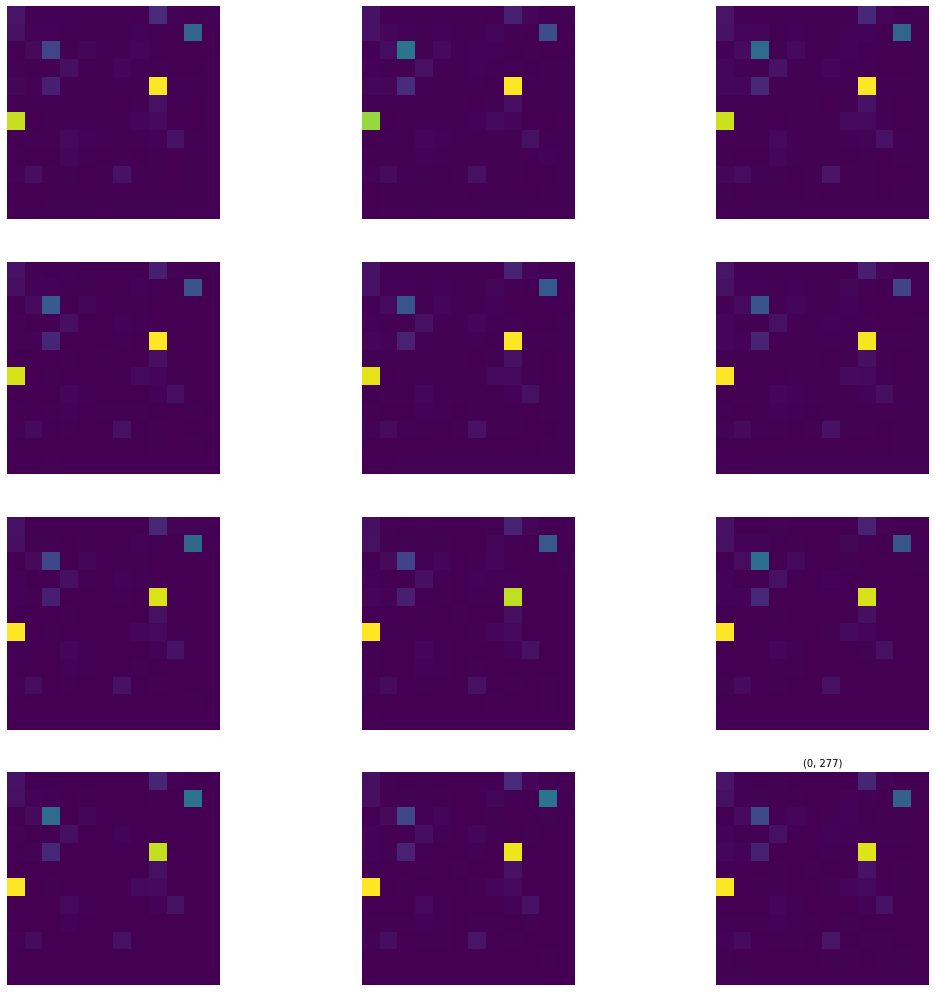

In [222]:
plot_ranom_images(0,380,12,X_tensors_train, y, (18,18), (4,3) , 10) #hleper function that takes out random sample from tensor, transmute them to the HWC format (matplotlib do not understand PyTorch native image format)

In [223]:
 # This time I'm using whole dataframe for y labels, because I have already prebuild PyTorch DataSet Class that will handle extracting y values.
train_tensor, test_tensor = train_test_split_ts(X_tensors_train, main, train_size=0.8)

In [224]:
X_train_tensor, y_train_tensor = train_tensor
X_test_tensor, y_test_tensor = test_tensor # unpacking tuples

In [225]:
def get_classes(series: pd.core.series.Series):

    classes = series.unique()
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

class MatchesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataframe: pd.core.frame.DataFrame, #dataframe of results, we will gety Y_labels from this
                 games: torch.Tensor, #tensor of X's
                 transform=None): #we will not be using any transorm at this stage, but I'll leave as a boiler plate for further usage.
        super().__init__()

        self.dataframe = dataframe #a dataframe as it it.
        self.games = games # our X's. We don't have to do anything with them, cause if we index this tensor, we will have a single image of a game from it.
        self.hda = self.dataframe["FTR"].to_numpy() #we are transforming pandas datafram to numpy array of Home/Draw/Away labels.
        self.classes, self.class_to_idx = get_classes(dataframe["FTR"]) #we are unpacking a function that will return us a mapped y labels.
        self.labels = torch.tensor(np.vectorize(self.class_to_idx.get)(self.hda)) #and here we are using np.vectorize to turn coresponding labels into values from 0 to 2 and then we turn them into a tensor.


    def __len__(self) -> int:
        return len(self.labels) #overwriting __len__

    def __getitem__(self, index: int): #overwriting __getitem__ and returning X&y's
    
        X = self.games[index]
        y = self.labels[index]
        
        return X,y


In [226]:
# Here we initialize a class to create a PyTorch Datasets
train_dataset = MatchesDataset(y_train_tensor,X_train_tensor) 
test_dataset = MatchesDataset(y_test_tensor,X_test_tensor)

In [227]:
#And this part of code is clustering data into minibatches and preparing an efficient datapipe for the CNN 
train_loader_tab2img = DataLoader(train_dataset, 16, shuffle=False) # we are not shuffling, to be consistent. 
test_loader_tab2img = DataLoader(test_dataset)

In [228]:
# It's not exactly a DeepInsight, but it's a similar, despite hyperparams may vary. Remember, it's a baseline only!
class DeepInsightStyleNN(nn.Module): 
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int,) -> None:


        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3_5 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            )
        
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10,
                      out_features=output_shape),
            nn.Softmax()
            )

    def forward(self, x):
        return self.classifier_layer(self.conv_block_3_5(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))   #for efficiency on cuda computing we are doing this in one line.

In [229]:
deep_in_model = DeepInsightStyleNN(input_shape=1,
                    hidden_units=10,
                    output_shape=np.unique(y).shape[0]).to(device) # initialize the model

In [230]:
deep_in_model.eval()
with torch.inference_mode():
    preds = deep_in_model(X_tensors_train) # check if the output have sense

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [231]:
preds.shape # indeed, it have proper shape.

torch.Size([380, 3])

In [232]:
#Here we have to define metrics, loss function and optimizer

optimizer_deep = torch.optim.Adam(deep_in_model.parameters(),lr=0.001) #Adam as an optimizer
loss_fn_deep = nn.CrossEntropyLoss() #Cause we are dealing with multicategory classification, we will use Cross Entropy
acc_deep = torchmetrics.Accuracy(3).to(device) #and we also initialize class from torchmetrics and send it to device(cuda). 

In [233]:
# And it's a training time
for epoch in tqdm(range(60)):

    print(f"Epoch: {epoch}\n======")

    train_step(deep_in_model,train_loader_tab2img,loss_fn_deep, optimizer_deep, acc_deep, device)
    test_step(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device)


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0

Current training loss: 1.092272400856018
Current training acc: 0.3486842215061188%




  2%|▏         | 1/60 [00:00<00:25,  2.27it/s]


Current test loss: 1.096718430519104
Current test acc: 0.2763157784938812%

Epoch: 1

Current training loss: 1.0616636276245117
Current training acc: 0.47697368264198303%




  3%|▎         | 2/60 [00:00<00:19,  3.00it/s]


Current test loss: 1.1197967529296875
Current test acc: 0.2763157784938812%

Epoch: 2

Current training loss: 1.04583740234375
Current training acc: 0.5625%




  5%|▌         | 3/60 [00:00<00:17,  3.22it/s]


Current test loss: 1.1758222579956055
Current test acc: 0.21052631735801697%

Epoch: 3

Current training loss: 1.034127950668335
Current training acc: 0.5723684430122375%




  7%|▋         | 4/60 [00:01<00:16,  3.48it/s]


Current test loss: 1.180324912071228
Current test acc: 0.28947368264198303%

Epoch: 4

Current training loss: 1.0239176750183105
Current training acc: 0.5855262875556946%




  8%|▊         | 5/60 [00:01<00:15,  3.66it/s]


Current test loss: 1.2086998224258423
Current test acc: 0.2368421107530594%

Epoch: 5

Current training loss: 1.0155783891677856
Current training acc: 0.5888158082962036%




 10%|█         | 6/60 [00:01<00:14,  3.62it/s]


Current test loss: 1.2090680599212646
Current test acc: 0.2631579041481018%

Epoch: 6

Current training loss: 1.0087099075317383
Current training acc: 0.5921052694320679%




 12%|█▏        | 7/60 [00:02<00:16,  3.28it/s]


Current test loss: 1.2026219367980957
Current test acc: 0.30263158679008484%

Epoch: 7

Current training loss: 1.002132534980774
Current training acc: 0.5756579041481018%




 13%|█▎        | 8/60 [00:02<00:14,  3.49it/s]


Current test loss: 1.2568411827087402
Current test acc: 0.21052631735801697%

Epoch: 8

Current training loss: 0.9975134134292603
Current training acc: 0.5855262875556946%




 15%|█▌        | 9/60 [00:02<00:13,  3.68it/s]


Current test loss: 1.2112016677856445
Current test acc: 0.2763157784938812%

Epoch: 9

Current training loss: 0.9925519824028015
Current training acc: 0.5855262875556946%




 17%|█▋        | 10/60 [00:02<00:13,  3.80it/s]


Current test loss: 1.2345926761627197
Current test acc: 0.25%

Epoch: 10

Current training loss: 0.9884960651397705
Current training acc: 0.5921052694320679%




 18%|█▊        | 11/60 [00:03<00:12,  3.90it/s]


Current test loss: 1.197988510131836
Current test acc: 0.25%

Epoch: 11

Current training loss: 0.9839898347854614
Current training acc: 0.5855262875556946%




 20%|██        | 12/60 [00:03<00:12,  3.91it/s]


Current test loss: 1.2370554208755493
Current test acc: 0.22368420660495758%

Epoch: 12

Current training loss: 0.9817593097686768
Current training acc: 0.5921052694320679%




 22%|██▏       | 13/60 [00:03<00:11,  3.96it/s]


Current test loss: 1.228173851966858
Current test acc: 0.22368420660495758%

Epoch: 13

Current training loss: 0.9791114330291748
Current training acc: 0.5888158082962036%




 23%|██▎       | 14/60 [00:03<00:11,  3.95it/s]


Current test loss: 1.247178077697754
Current test acc: 0.22368420660495758%

Epoch: 14

Current training loss: 0.9757310152053833
Current training acc: 0.5855262875556946%




 25%|██▌       | 15/60 [00:04<00:11,  3.94it/s]


Current test loss: 1.2259665727615356
Current test acc: 0.28947368264198303%

Epoch: 15

Current training loss: 0.973044216632843
Current training acc: 0.5855262875556946%




 27%|██▋       | 16/60 [00:04<00:14,  3.10it/s]


Current test loss: 1.2354564666748047
Current test acc: 0.22368420660495758%

Epoch: 16

Current training loss: 0.9717225432395935
Current training acc: 0.5855262875556946%




 28%|██▊       | 17/60 [00:04<00:14,  2.93it/s]


Current test loss: 1.221290946006775
Current test acc: 0.2631579041481018%

Epoch: 17

Current training loss: 0.9686367511749268
Current training acc: 0.5855262875556946%




 30%|███       | 18/60 [00:05<00:15,  2.69it/s]


Current test loss: 1.2517893314361572
Current test acc: 0.21052631735801697%

Epoch: 18

Current training loss: 0.9674179553985596
Current training acc: 0.5822368264198303%




 32%|███▏      | 19/60 [00:05<00:16,  2.49it/s]


Current test loss: 1.2360882759094238
Current test acc: 0.21052631735801697%

Epoch: 19

Current training loss: 0.9645915031433105
Current training acc: 0.5888158082962036%




 33%|███▎      | 20/60 [00:06<00:17,  2.34it/s]


Current test loss: 1.2522460222244263
Current test acc: 0.25%

Epoch: 20

Current training loss: 0.9679581522941589
Current training acc: 0.5822368264198303%




 35%|███▌      | 21/60 [00:06<00:17,  2.27it/s]


Current test loss: 1.2621546983718872
Current test acc: 0.30263158679008484%

Epoch: 21

Current training loss: 0.9641371369361877
Current training acc: 0.5921052694320679%




 37%|███▋      | 22/60 [00:07<00:16,  2.27it/s]


Current test loss: 1.287172794342041
Current test acc: 0.19736842811107635%

Epoch: 22

Current training loss: 0.9601505398750305
Current training acc: 0.5888158082962036%




 38%|███▊      | 23/60 [00:07<00:15,  2.38it/s]


Current test loss: 1.2321215867996216
Current test acc: 0.25%

Epoch: 23

Current training loss: 0.9623458981513977
Current training acc: 0.5756579041481018%




 40%|████      | 24/60 [00:08<00:15,  2.38it/s]


Current test loss: 1.2425380945205688
Current test acc: 0.30263158679008484%

Epoch: 24

Current training loss: 0.959081768989563
Current training acc: 0.5855262875556946%




 42%|████▏     | 25/60 [00:08<00:15,  2.25it/s]


Current test loss: 1.2307257652282715
Current test acc: 0.2631579041481018%

Epoch: 25

Current training loss: 0.9568836688995361
Current training acc: 0.5789473652839661%




 43%|████▎     | 26/60 [00:09<00:14,  2.28it/s]


Current test loss: 1.282395839691162
Current test acc: 0.22368420660495758%

Epoch: 26

Current training loss: 0.9638016223907471
Current training acc: 0.5690789222717285%




 45%|████▌     | 27/60 [00:09<00:14,  2.23it/s]


Current test loss: 1.2540743350982666
Current test acc: 0.30263158679008484%

Epoch: 27

Current training loss: 0.9587098360061646
Current training acc: 0.5888158082962036%




 47%|████▋     | 28/60 [00:09<00:14,  2.19it/s]


Current test loss: 1.2796016931533813
Current test acc: 0.22368420660495758%

Epoch: 28

Current training loss: 0.9546994566917419
Current training acc: 0.5855262875556946%




 48%|████▊     | 29/60 [00:10<00:15,  2.06it/s]


Current test loss: 1.2516459226608276
Current test acc: 0.21052631735801697%

Epoch: 29

Current training loss: 0.953193187713623
Current training acc: 0.5789473652839661%




 50%|█████     | 30/60 [00:11<00:14,  2.04it/s]


Current test loss: 1.2750598192214966
Current test acc: 0.22368420660495758%

Epoch: 30

Current training loss: 0.9523701667785645
Current training acc: 0.5855262875556946%




 52%|█████▏    | 31/60 [00:11<00:15,  1.91it/s]


Current test loss: 1.229172945022583
Current test acc: 0.2763157784938812%

Epoch: 31

Current training loss: 0.9501519203186035
Current training acc: 0.5888158082962036%




 53%|█████▎    | 32/60 [00:12<00:13,  2.02it/s]


Current test loss: 1.2496956586837769
Current test acc: 0.30263158679008484%

Epoch: 32

Current training loss: 0.9550756216049194
Current training acc: 0.5822368264198303%




 55%|█████▌    | 33/60 [00:12<00:13,  1.96it/s]


Current test loss: 1.2770421504974365
Current test acc: 0.2631579041481018%

Epoch: 33

Current training loss: 0.9475957155227661
Current training acc: 0.5855262875556946%




 57%|█████▋    | 34/60 [00:13<00:12,  2.07it/s]


Current test loss: 1.251758337020874
Current test acc: 0.2763157784938812%

Epoch: 34

Current training loss: 0.9447444081306458
Current training acc: 0.5921052694320679%




 58%|█████▊    | 35/60 [00:13<00:12,  2.08it/s]


Current test loss: 1.2580451965332031
Current test acc: 0.2631579041481018%

Epoch: 35

Current training loss: 0.9509104490280151
Current training acc: 0.5789473652839661%




 60%|██████    | 36/60 [00:14<00:12,  2.00it/s]


Current test loss: 1.2423977851867676
Current test acc: 0.30263158679008484%

Epoch: 36

Current training loss: 0.9464701414108276
Current training acc: 0.5855262875556946%




 62%|██████▏   | 37/60 [00:14<00:12,  1.88it/s]


Current test loss: 1.2529654502868652
Current test acc: 0.30263158679008484%

Epoch: 37

Current training loss: 0.9444690346717834
Current training acc: 0.5921052694320679%




 63%|██████▎   | 38/60 [00:15<00:12,  1.80it/s]


Current test loss: 1.2759681940078735
Current test acc: 0.2763157784938812%

Epoch: 38

Current training loss: 0.9426536560058594
Current training acc: 0.5921052694320679%




 65%|██████▌   | 39/60 [00:15<00:10,  1.92it/s]


Current test loss: 1.297403335571289
Current test acc: 0.19736842811107635%

Epoch: 39

Current training loss: 0.9404643177986145
Current training acc: 0.6118420958518982%




 67%|██████▋   | 40/60 [00:16<00:11,  1.77it/s]


Current test loss: 1.263085961341858
Current test acc: 0.28947368264198303%

Epoch: 40

Current training loss: 0.9388298392295837
Current training acc: 0.5986841917037964%




 68%|██████▊   | 41/60 [00:16<00:10,  1.83it/s]


Current test loss: 1.2761811017990112
Current test acc: 0.2763157784938812%

Epoch: 41

Current training loss: 0.9344448447227478
Current training acc: 0.6052631735801697%




 70%|███████   | 42/60 [00:17<00:09,  1.84it/s]


Current test loss: 1.2501935958862305
Current test acc: 0.30263158679008484%

Epoch: 42

Current training loss: 0.9341363310813904
Current training acc: 0.6118420958518982%




 72%|███████▏  | 43/60 [00:17<00:08,  1.89it/s]


Current test loss: 1.1737260818481445
Current test acc: 0.2763157784938812%

Epoch: 43

Current training loss: 0.9307445883750916
Current training acc: 0.6151315569877625%




 73%|███████▎  | 44/60 [00:18<00:09,  1.65it/s]


Current test loss: 1.2610692977905273
Current test acc: 0.2631579041481018%

Epoch: 44

Current training loss: 0.9276437163352966
Current training acc: 0.6118420958518982%




 75%|███████▌  | 45/60 [00:19<00:09,  1.62it/s]


Current test loss: 1.147242546081543
Current test acc: 0.3947368562221527%

Epoch: 45

Current training loss: 0.9302641153335571
Current training acc: 0.6151315569877625%




 77%|███████▋  | 46/60 [00:19<00:08,  1.58it/s]


Current test loss: 1.2606151103973389
Current test acc: 0.21052631735801697%

Epoch: 46

Current training loss: 0.9316221475601196
Current training acc: 0.625%




 78%|███████▊  | 47/60 [00:20<00:07,  1.71it/s]


Current test loss: 1.2509022951126099
Current test acc: 0.30263158679008484%

Epoch: 47

Current training loss: 0.9310534596443176
Current training acc: 0.6052631735801697%




 80%|████████  | 48/60 [00:21<00:06,  1.72it/s]


Current test loss: 1.17892324924469
Current test acc: 0.3552631437778473%

Epoch: 48

Current training loss: 0.9210638999938965
Current training acc: 0.6348684430122375%




 82%|████████▏ | 49/60 [00:21<00:06,  1.70it/s]


Current test loss: 1.288888931274414
Current test acc: 0.19736842811107635%

Epoch: 49

Current training loss: 0.9213156700134277
Current training acc: 0.625%




 83%|████████▎ | 50/60 [00:22<00:06,  1.65it/s]


Current test loss: 1.2663367986679077
Current test acc: 0.25%

Epoch: 50

Current training loss: 0.9189607501029968
Current training acc: 0.6217105388641357%




 85%|████████▌ | 51/60 [00:22<00:05,  1.77it/s]


Current test loss: 1.2056355476379395
Current test acc: 0.31578946113586426%

Epoch: 51

Current training loss: 0.9135068655014038
Current training acc: 0.6447368264198303%




 87%|████████▋ | 52/60 [00:23<00:04,  1.82it/s]


Current test loss: 1.271794319152832
Current test acc: 0.18421052396297455%

Epoch: 52

Current training loss: 0.9209580421447754
Current training acc: 0.6348684430122375%




 88%|████████▊ | 53/60 [00:23<00:03,  1.81it/s]


Current test loss: 1.3338534832000732
Current test acc: 0.19736842811107635%

Epoch: 53

Current training loss: 0.9141748547554016
Current training acc: 0.6381579041481018%




 90%|█████████ | 54/60 [00:24<00:02,  2.09it/s]


Current test loss: 1.2820111513137817
Current test acc: 0.2368421107530594%

Epoch: 54

Current training loss: 0.9120646119117737
Current training acc: 0.6513158082962036%




 92%|█████████▏| 55/60 [00:24<00:02,  2.45it/s]


Current test loss: 1.2402162551879883
Current test acc: 0.28947368264198303%

Epoch: 55

Current training loss: 0.9357267618179321
Current training acc: 0.6315789222717285%




 93%|█████████▎| 56/60 [00:24<00:01,  2.78it/s]


Current test loss: 1.2570174932479858
Current test acc: 0.30263158679008484%

Epoch: 56

Current training loss: 0.9298459887504578
Current training acc: 0.6085526347160339%




 95%|█████████▌| 57/60 [00:24<00:00,  3.10it/s]


Current test loss: 1.2637008428573608
Current test acc: 0.28947368264198303%

Epoch: 57

Current training loss: 0.9254694581031799
Current training acc: 0.6381579041481018%




 97%|█████████▋| 58/60 [00:25<00:00,  3.29it/s]


Current test loss: 1.1366766691207886
Current test acc: 0.3815789520740509%

Epoch: 58

Current training loss: 0.9177716970443726
Current training acc: 0.6381579041481018%




 98%|█████████▊| 59/60 [00:25<00:00,  3.46it/s]


Current test loss: 1.285136342048645
Current test acc: 0.22368420660495758%

Epoch: 59

Current training loss: 0.9125571250915527
Current training acc: 0.6315789222717285%




100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


Current test loss: 1.2123827934265137
Current test acc: 0.2631579041481018%



In [234]:
model_deep_insight_evaluation = eval_model(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device) # IT will create a dictionary with data

100%|██████████| 76/76 [00:00<00:00, 670.31it/s]


In [235]:
deep_insight_preds = torch.stack(model_deep_insight_evaluation["model_preds"]).squeeze().argmax(dim=1) ## hmmm some weird issue, cause it's downloading 

In [236]:
deep_insight_acc = model_deep_insight_evaluation["model_acc"]; deep_insight_acc

0.2631579041481018

In [237]:
deep_insight_compare, deep_insight_score = check_score(main, deep_insight_preds.numpy()) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [238]:
deep_insight_score #Even though we are more then two times lower on accuracy, we are quite high in the terms of the betting odds summary. It seems to be very interesting...

57.62

In [239]:
# Let's analyze this predictions a bit.
deep_insight_compare.describe()

,FTR,predictions,AvgH,AvgA,AvgD,score_odds
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,1.631579,1.631579,4.576316,3.607368,4.474211,3.032632
std,0.495595,0.495595,3.708976,2.642461,0.972627,1.377396
min,1.000000,1.000000,1.360000,1.260000,3.320000,1.260000
25%,1.000000,1.000000,1.885000,1.425000,3.575000,1.425000
50%,2.000000,2.000000,2.670000,2.610000,4.580000,3.520000
75%,2.000000,2.000000,7.580000,4.360000,4.930000,3.760000
max,2.000000,2.000000,12.830000,9.620000,6.450000,4.950000


In [240]:
avg_odds_per_bet_di = deep_insight_compare.describe().loc["mean"]["score_odds"]

# PyTorch Tab2Img / DeepInsight results
I ran it a couple of times, but it looks completly random at this stage. But I'll give it a try anyway.

# Summary

The aim of this notebook was to compare four baseline models, and how far we are from beating the bookkeepers. Without tuning, with close to default hyperparams, we have the following output.

In [271]:
compare_dict = {"TabNet":{"score":score_tabnet,
                        "acc":tabnet_accuracy,
                        "avg_odds":avg_odds_per_bet_tabnet},
              "XGB":{"score":score_xgb,
                        "acc":xgboost_acc_test,
                     "avg_odds":avg_odds_per_bet_xgb},
              "RandomForest":{"score":score_rf,
                        "acc":rf_acc,
                        "avg_odds":avg_odds_per_bet_rf},
                "DeepInsight":{"score":deep_insight_score,
                        "acc":deep_insight_acc,
                        "avg_odds":avg_odds_per_bet_di},
                "TargetValues":{"score":76,
                        "acc":round(1/sum_of_odds*100, 4),
                        "avg_odds":(163*1.16+129*1.78+3.37*88)/380}}


compare_df = pd.DataFrame.from_dict(compare_dict).T ; compare_df

,score,acc,avg_odds
TabNet,92.46,0.592105,2.054667
XGB,75.53,0.552632,1.798333
RandomForest,73.40,0.539474,1.790244
DeepInsight,57.62,0.263158,3.032632
TargetValues,76.00,53.151900,1.882263


## TabNet we may consider already working Proof of Concept
With baseline TabNet params we are close to guessing 2 out of 3 games, so it's a very good start. But there is absolutely something worthy consideration in this DeepInsight approach. Maybe upscaling, maybe adding some layers, maybe some data manipulation and transormations... 

Nevertheless - it was all about understanding the baseline, and here we go - the baseline is already working Proof of Concept!